# Decision-Tree Based Model Evaluation on Credit Card Default Dataset

## Import libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import (
    classification_report,
    confusion_matrix,
    roc_auc_score,
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
)

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

import warnings
warnings.filterwarnings("ignore")

## Load the dataset

In [2]:
df = pd.read_csv("UCI_Credit_Card.csv")
print("Dataset shape:", df.shape)
df.head()

Dataset shape: (30000, 25)


,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


## Check for missing values

In [3]:
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64


## Separate dataset to X (features) and y (target)

In [4]:
X = df.drop(columns=['ID', 'default.payment.next.month'])
y = df['default.payment.next.month']

## Data type formatting

In [5]:
categorical_cols = ["SEX", "EDUCATION", "MARRIAGE"] + ["PAY_0"] + [f"PAY_{i}" for i in range(2, 7)]
for col in categorical_cols:
    X[col] = X[col].astype(int)

X["AGE"] = X["AGE"].astype(int)
y = y.astype(int)

In [6]:
X.head()

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,...,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6
0,20000.0,2,2,1,24,2,2,-1,-1,-2,...,689.0,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0
1,120000.0,2,2,2,26,-1,2,0,0,0,...,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0
2,90000.0,2,2,2,34,0,0,0,0,0,...,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0
3,50000.0,2,2,1,37,0,0,0,0,0,...,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0
4,50000.0,1,2,1,57,-1,0,-1,0,0,...,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0


## Data Encoding

In [7]:
X = pd.get_dummies(X, columns=['MARRIAGE', 'SEX', 'EDUCATION'], drop_first=True, dtype=int)
X.head()

,LIMIT_BAL,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,...,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,EDUCATION_6
0,20000.0,24,2,2,-1,-1,-2,-2,3913.0,3102.0,...,1,0,0,1,0,1,0,0,0,0
1,120000.0,26,-1,2,0,0,0,2,2682.0,1725.0,...,0,1,0,1,0,1,0,0,0,0
2,90000.0,34,0,0,0,0,0,0,29239.0,14027.0,...,0,1,0,1,0,1,0,0,0,0
3,50000.0,37,0,0,0,0,0,0,46990.0,48233.0,...,1,0,0,1,0,1,0,0,0,0
4,50000.0,57,-1,0,-1,0,0,0,8617.0,5670.0,...,1,0,0,0,0,1,0,0,0,0


## Feature Engineering

In [8]:
def feature_engineering(df):
    df = df.copy()

    bill_cols = [f"BILL_AMT{i}" for i in range(1, 7)]
    pay_cols = [f"PAY_AMT{i}" for i in range(1, 7)]
    delay_cols = ["PAY_0"] + [f"PAY_{i}" for i in range(2, 7)]

    # Average bill and payment
    df["avg_bill_amt"] = df[bill_cols].mean(axis=1)
    df["avg_pay_amt"] = df[pay_cols].mean(axis=1)

    # Credit utilization
    df["credit_utilization"] = df["avg_bill_amt"] / (df["LIMIT_BAL"] + 1)

    # Payment ratios
    for i in range(1, 7):
        df[f"pay_ratio_{i}"] = df[f"PAY_AMT{i}"] / (df[f"BILL_AMT{i}"] + 1)

    # Delay behavior
    df["max_delay"] = df[delay_cols].max(axis=1)
    df["mean_delay"] = df[delay_cols].mean(axis=1)
    df["delay_count"] = (df[delay_cols] > 0).sum(axis=1)
    df["pay_trend"] = df[delay_cols].mean(axis=1)

    # Bill and payment trends (slope)
    df["bill_trend_slope"] = df[bill_cols].apply(lambda row: np.polyfit(range(6), row.values, 1)[0], axis=1)
    df["pay_amt_trend_slope"] = df[pay_cols].apply(lambda row: np.polyfit(range(6), row.values, 1)[0], axis=1)

    # Bill ratio and pay credit ratio
    for i in range(1, 7):
        df[f"bill_ratio_{i}"] = df[f"BILL_AMT{i}"] / (df["LIMIT_BAL"] + 1)
    for i in range(1, 7):
        df[f"pay_credit_ratio_{i}"] = df[f"PAY_AMT{i}"] / (df["LIMIT_BAL"] + 1)

    # Encode Pay columns
    df = pd.get_dummies(df, columns=delay_cols, drop_first=True, dtype=int)

    return df


In [9]:
X_fe = feature_engineering(X)
X_fe.head()

,LIMIT_BAL,AGE,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,...,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
0,20000.0,24,3913.0,3102.0,689.0,0.0,0.0,0.0,0.0,689.0,...,0,0,0,0,0,0,0,0,0,0
1,120000.0,26,2682.0,1725.0,2682.0,3272.0,3455.0,3261.0,0.0,1000.0,...,0,0,0,1,0,0,0,0,0,0
2,90000.0,34,29239.0,14027.0,13559.0,14331.0,14948.0,15549.0,1518.0,1500.0,...,0,0,1,0,0,0,0,0,0,0
3,50000.0,37,46990.0,48233.0,49291.0,28314.0,28959.0,29547.0,2000.0,2019.0,...,0,0,1,0,0,0,0,0,0,0
4,50000.0,57,8617.0,5670.0,35835.0,20940.0,19146.0,19131.0,2000.0,36681.0,...,0,0,1,0,0,0,0,0,0,0


## Split to training and test set

In [10]:
X_train, X_test, y_train, y_test = train_test_split(
    X_fe,
    y,
    test_size=0.2,
    random_state=21
)

In [11]:
X_train_int = X_train.select_dtypes(include=['int64'])
X_train_float = X_train.select_dtypes(include=['float64'])
train_feature_names = pd.concat([X_train_int, X_train_float], axis=1).columns.tolist()
print(f"There are {len(train_feature_names)} training set feature names")

X_test_int = X_test[X_train_int.columns].astype('int64')
X_test_float = X_test[X_train_float.columns].astype('float64')
test_feature_names = pd.concat([X_test_int, X_test_float], axis=1).columns.tolist()
print(f"There are {len(test_feature_names)} training set feature names")

print("Feature names", train_feature_names)

There are 109 training set feature names
There are 109 training set feature names
Feature names ['AGE', 'MARRIAGE_1', 'MARRIAGE_2', 'MARRIAGE_3', 'SEX_2', 'EDUCATION_1', 'EDUCATION_2', 'EDUCATION_3', 'EDUCATION_4', 'EDUCATION_5', 'EDUCATION_6', 'max_delay', 'delay_count', 'PAY_0_-1', 'PAY_0_0', 'PAY_0_1', 'PAY_0_2', 'PAY_0_3', 'PAY_0_4', 'PAY_0_5', 'PAY_0_6', 'PAY_0_7', 'PAY_0_8', 'PAY_2_-1', 'PAY_2_0', 'PAY_2_1', 'PAY_2_2', 'PAY_2_3', 'PAY_2_4', 'PAY_2_5', 'PAY_2_6', 'PAY_2_7', 'PAY_2_8', 'PAY_3_-1', 'PAY_3_0', 'PAY_3_1', 'PAY_3_2', 'PAY_3_3', 'PAY_3_4', 'PAY_3_5', 'PAY_3_6', 'PAY_3_7', 'PAY_3_8', 'PAY_4_-1', 'PAY_4_0', 'PAY_4_1', 'PAY_4_2', 'PAY_4_3', 'PAY_4_4', 'PAY_4_5', 'PAY_4_6', 'PAY_4_7', 'PAY_4_8', 'PAY_5_-1', 'PAY_5_0', 'PAY_5_2', 'PAY_5_3', 'PAY_5_4', 'PAY_5_5', 'PAY_5_6', 'PAY_5_7', 'PAY_5_8', 'PAY_6_-1', 'PAY_6_0', 'PAY_6_2', 'PAY_6_3', 'PAY_6_4', 'PAY_6_5', 'PAY_6_6', 'PAY_6_7', 'PAY_6_8', 'LIMIT_BAL', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL

In [12]:
X_train_int.head()

,AGE,MARRIAGE_1,MARRIAGE_2,MARRIAGE_3,SEX_2,EDUCATION_1,EDUCATION_2,EDUCATION_3,EDUCATION_4,EDUCATION_5,...,PAY_5_8,PAY_6_-1,PAY_6_0,PAY_6_2,PAY_6_3,PAY_6_4,PAY_6_5,PAY_6_6,PAY_6_7,PAY_6_8
11797,33,1,0,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
7158,30,0,1,0,1,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0
23778,50,0,1,0,1,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
22,26,0,1,0,1,0,1,0,0,0,...,0,0,0,1,0,0,0,0,0,0
29414,28,0,1,0,0,0,1,0,0,0,...,0,0,1,0,0,0,0,0,0,0


In [13]:
X_train_float.head()

,LIMIT_BAL,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,...,bill_ratio_3,bill_ratio_4,bill_ratio_5,bill_ratio_6,pay_credit_ratio_1,pay_credit_ratio_2,pay_credit_ratio_3,pay_credit_ratio_4,pay_credit_ratio_5,pay_credit_ratio_6
11797,120000.0,46640.0,50865.0,54401.0,57873.0,61917.0,63880.0,5000.0,5000.0,5000.0,...,0.453338,0.482271,0.515971,0.532329,0.041666,0.041666,0.041666,0.041666,0.025000,0.025000
7158,180000.0,63182.0,64274.0,55112.0,56394.0,57577.0,58564.0,2166.0,2002.0,2200.0,...,0.306176,0.313298,0.319870,0.325354,0.012033,0.011122,0.012222,0.012455,0.011667,0.012944
23778,50000.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
22,70000.0,41087.0,42445.0,45020.0,44006.0,46905.0,46012.0,2007.0,3582.0,0.0,...,0.643134,0.628648,0.670062,0.657305,0.028671,0.051171,0.000000,0.051442,0.000000,0.026000
29414,130000.0,101546.0,88549.0,74624.0,76133.0,77648.0,79370.0,3000.0,2709.0,2750.0,...,0.574026,0.585634,0.597288,0.610534,0.023077,0.020838,0.021154,0.021284,0.022777,0.022408


## Data Scaling

In [14]:
X_train_float.replace([np.inf, -np.inf], np.nan, inplace=True)
X_test_float.replace([np.inf, -np.inf], np.nan, inplace=True)

median_vals = X_train_float.mean()
X_train_float.fillna(median_vals, inplace=True)
X_test_float.fillna(median_vals, inplace=True)


scaler = StandardScaler()
X_train_float_scaled = scaler.fit_transform(X_train_float)
X_test_float_scaled = scaler.transform(X_test_float)

In [15]:
X_train_final = np.hstack((X_train_int, X_train_float_scaled))
X_test_final = np.hstack((X_test_int, X_test_float_scaled))

## Hyperparameters and GridSearch Values Definition

In [16]:
models = {
    "DecisionTree": (
        DecisionTreeClassifier(random_state=21),
        {
            "max_depth": [4, 6, 8, None],
            "min_samples_leaf": [5, 20, 50]
        }
    ),

    "RandomForest": (
        RandomForestClassifier(
            n_estimators=300,
            random_state=21,
            n_jobs=-1
        ),
        {
            "max_depth": [6, 10, None],
            "min_samples_leaf": [5, 20],
            "max_features": ["sqrt", "log2"]
        }
    ),

    "GradientBoosting": (
        GradientBoostingClassifier(random_state=21),
        {
            "learning_rate": [0.05, 0.1],
            "n_estimators": [200, 300],
            "max_depth": [3, 5]
        }
    ),

    "XGBoost": (
        XGBClassifier(
            eval_metric="logloss",
            random_state=21,
            n_jobs=-1
        ),
        {
            "n_estimators": [300, 500],
            "max_depth": [4, 6],
            "learning_rate": [0.05, 0.1],
            "subsample": [0.8, 1.0],
            "colsample_bytree": [0.8, 1.0]
        }
    )
}


## Plot Feature Importances

In [17]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_feature_importance(model, feature_names, top_n=5, title="Feature Importance"):
    """
    Plot feature importance for tree-based models
    """
    importances = model.feature_importances_

    fi_df = pd.DataFrame({
        "feature": feature_names,
        "importance": importances
    }).sort_values(by="importance", ascending=False)

    # Print top features
    print(f"\nTop {top_n} Features:")
    print(fi_df.head(top_n))

    # Plot
    plt.figure(figsize=(8, 6))
    plt.barh(
        fi_df.head(top_n)["feature"][::-1],
        fi_df.head(top_n)["importance"][::-1]
    )
    plt.xlabel("Importance Score")
    plt.title(title)
    plt.tight_layout()
    plt.show()

    return fi_df


## Model Training and Model Evaluation


===== TRAINING DecisionTree =====
Best Params: {'max_depth': 6, 'min_samples_leaf': 50}
Classification Metrics     roc_auc  accuracy  precision    recall  f1_score
0  0.766223  0.815167   0.690209  0.319465   0.43677
Classification Report:
              precision    recall  f1-score   support

           0       0.83      0.96      0.89      4654
           1       0.69      0.32      0.44      1346

    accuracy                           0.82      6000
   macro avg       0.76      0.64      0.66      6000
weighted avg       0.80      0.82      0.79      6000

Confusion Matrix:


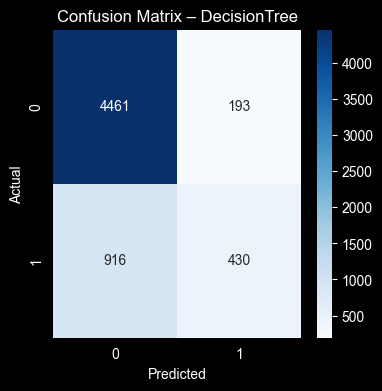


Top 5 Features:
         feature  importance
11     max_delay    0.560605
16       PAY_0_2    0.156795
94     pay_trend    0.076658
84  avg_bill_amt    0.050512
17       PAY_0_3    0.016243


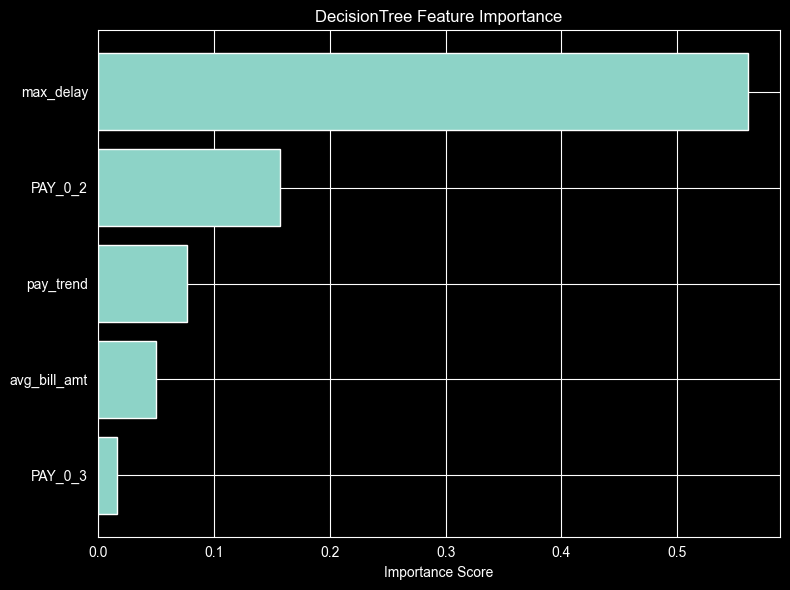


===== TRAINING RandomForest =====
Best Params: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 20}
Classification Metrics     roc_auc  accuracy  precision    recall  f1_score
0  0.783416  0.821833   0.689466  0.374443  0.485315
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4654
           1       0.69      0.37      0.49      1346

    accuracy                           0.82      6000
   macro avg       0.76      0.66      0.69      6000
weighted avg       0.81      0.82      0.80      6000

Confusion Matrix:


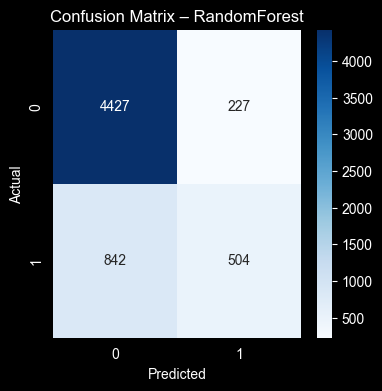


Top 5 Features:
        feature  importance
16      PAY_0_2    0.095760
11    max_delay    0.094290
94    pay_trend    0.080878
12  delay_count    0.080470
93   mean_delay    0.076756


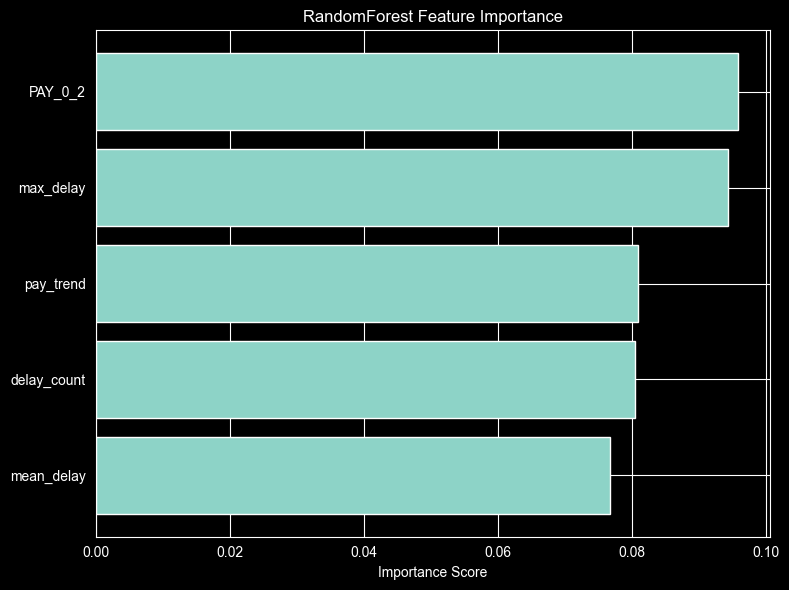


===== TRAINING GradientBoosting =====
Best Params: {'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 200}
Classification Metrics     roc_auc  accuracy  precision    recall  f1_score
0  0.785019  0.820167   0.684138  0.368499  0.478996
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4654
           1       0.68      0.37      0.48      1346

    accuracy                           0.82      6000
   macro avg       0.76      0.66      0.69      6000
weighted avg       0.80      0.82      0.80      6000

Confusion Matrix:


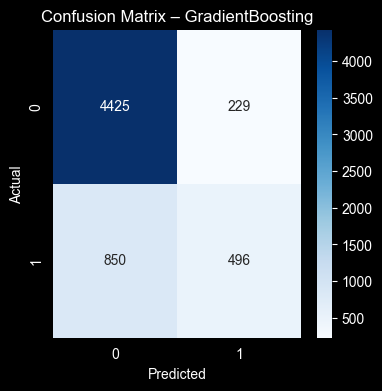


Top 5 Features:
        feature  importance
11    max_delay    0.330607
16      PAY_0_2    0.136153
93   mean_delay    0.129994
94    pay_trend    0.070604
12  delay_count    0.068352


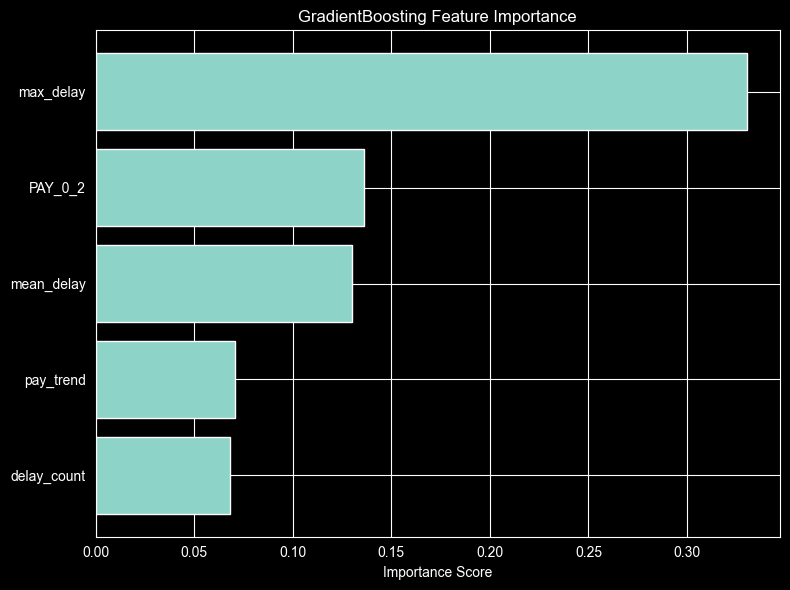


===== TRAINING XGBoost =====
Best Params: {'colsample_bytree': 1.0, 'learning_rate': 0.05, 'max_depth': 4, 'n_estimators': 300, 'subsample': 0.8}
Classification Metrics     roc_auc  accuracy  precision  recall  f1_score
0  0.785352  0.820667   0.683424  0.3737  0.483189
Classification Report:
              precision    recall  f1-score   support

           0       0.84      0.95      0.89      4654
           1       0.68      0.37      0.48      1346

    accuracy                           0.82      6000
   macro avg       0.76      0.66      0.69      6000
weighted avg       0.80      0.82      0.80      6000

Confusion Matrix:


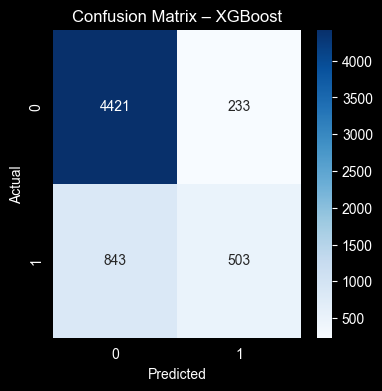


Top 5 Features:
        feature  importance
11    max_delay    0.309510
16      PAY_0_2    0.087777
26      PAY_2_2    0.034231
12  delay_count    0.034051
93   mean_delay    0.027020


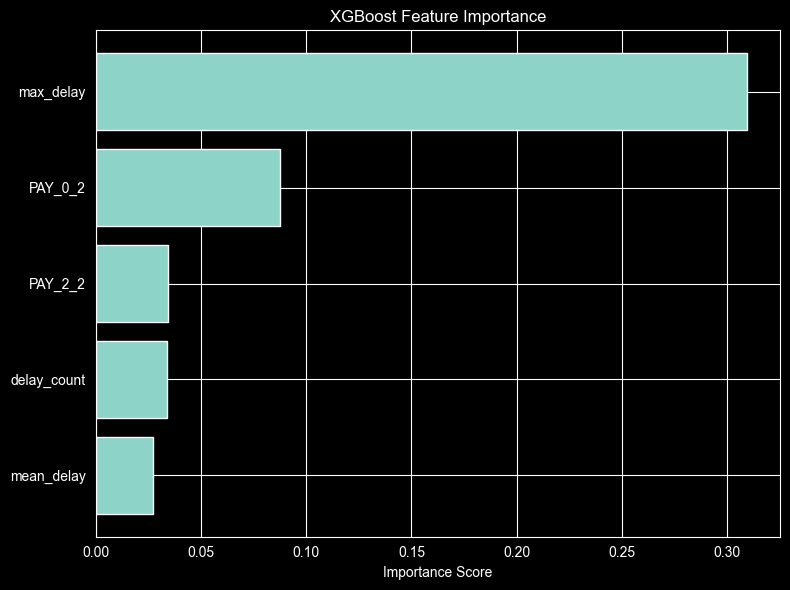

In [18]:
results = {}

for name, (model, param_grid) in models.items():
    print(f"\n===== TRAINING {name} =====")

    grid = GridSearchCV(
        model,
        param_grid=param_grid,
        scoring="roc_auc",
        cv=3,
        n_jobs=-1
    )

    grid.fit(X_train_final, y_train)

    best_model = grid.best_estimator_

    y_pred = best_model.predict(X_test_final)
    y_prob = best_model.predict_proba(X_test_final)[:, 1]

    results[name] = {
        "roc_auc": roc_auc_score(y_test, y_prob),
        "accuracy": accuracy_score(y_test, y_pred),
        "precision": precision_score(y_test, y_pred),
        "recall": recall_score(y_test, y_pred),
        "f1_score": f1_score(y_test, y_pred),
    }

    print("Best Params:", grid.best_params_)
    print("Classification Metrics", pd.DataFrame([results[name]]))
    print("Classification Report:")
    print(classification_report(y_test, y_pred))

    print("Confusion Matrix:")
    cm = confusion_matrix(y_test, y_pred)
    plt.figure(figsize=(4, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
    plt.title(f"Confusion Matrix – {name}")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    plot_feature_importance(
        model=best_model,
        feature_names=train_feature_names,
        top_n=5,
        title=f"{name} Feature Importance"
    )

In [21]:
score_df = pd.DataFrame(results)
score_df.T[['accuracy', 'precision', 'recall', 'f1_score', 'roc_auc']]

,accuracy,precision,recall,f1_score,roc_auc
DecisionTree,0.815167,0.690209,0.319465,0.436770,0.766223
RandomForest,0.821833,0.689466,0.374443,0.485315,0.783416
GradientBoosting,0.820167,0.684138,0.368499,0.478996,0.785019
XGBoost,0.820667,0.683424,0.373700,0.483189,0.785352
